# ICD-11 Vectorization

## 1. Data Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import json

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Load the ICD-11 data
icd11_df = pd.read_csv('icd11_data_raw.csv')

icd11_df.head()

,id,code,title,browser_url,class_kind,definition,parent,inclusions,foundation_children,foundation_child_references,index_terms,related_entities,full_text,children,postcoordination_scales,index_term_references,exclusions,exclusion_references,fully_specified_name
0,1937339080,1C22,Infections due to Chlamydia psittaci,https://icd.who.int/browse/2023-01/mms/en#1937...,category,Any condition caused by an infection with the ...,1127435854,Psittacosis; Ornithosis; Parrot fever,Pneumonia in chlamydia psittaci infection,Pneumonia in chlamydia psittaci infection: htt...,Infections due to Chlamydia psittaci; Psittaco...,1935107489,Infections due to Chlamydia psittaci Any condi...,NaN,NaN,NaN,NaN,NaN,NaN
1,1671640403,1F51.0,Gambiense trypanosomiasis,https://icd.who.int/browse/2023-01/mms/en#1671...,category,A disease caused by an infection with the prot...,875488052,West African sleeping sickness; Infection due ...,NaN,NaN,NaN,1945127438,Gambiense trypanosomiasis A disease caused by ...,1842725899; other; unspecified,"{'axis_name': 'hasManifestation', 'required': ...",NaN,NaN,NaN,NaN
2,1528414070,1A07,Typhoid fever,https://icd.who.int/browse/2023-01/mms/en#1528...,category,A condition caused by an infection with the gr...,135352227,NaN,NaN,NaN,NaN,911707612,Typhoid fever A condition caused by an infecti...,364534567; other; unspecified,"{'axis_name': 'hasManifestation', 'required': ...",NaN,NaN,NaN,NaN
3,328097188,1A36.12,Cutaneous amoebiasis,https://icd.who.int/browse/2023-01/mms/en#3280...,category,NaN,1777228366,NaN,NaN,NaN,Cutaneous amoebiasis; Amoebiasis of skin; Amoe...,911707612,Cutaneous amoebiasis Cutaneous amoebiasis; Amo...,NaN,NaN,NaN,NaN,NaN,NaN
4,1483190070,1D03,Infectious abscess of the central nervous system,https://icd.who.int/browse/2023-01/mms/en#1483...,category,A focal suppurative process of the brain paren...,1585949804,NaN,NaN,NaN,NaN,911707612,Infectious abscess of the central nervous syst...,443087096; 613341872; 1147230459; 1128677700; ...,"{'axis_name': 'specificAnatomy', 'required': '...",NaN,NaN,NaN,NaN


In [ ]:
icd11_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8955 entries, 0 to 8954
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           8955 non-null   int64 
 1   code                         8397 non-null   object
 2   title                        8955 non-null   object
 3   browser_url                  8955 non-null   object
 4   class_kind                   8955 non-null   object
 5   definition                   5992 non-null   object
 6   parent                       8955 non-null   object
 7   inclusions                   858 non-null    object
 8   foundation_children          1307 non-null   object
 9   foundation_child_references  1307 non-null   object
 10  index_terms                  6890 non-null   object
 11  related_entities             2091 non-null   object
 12  full_text                    8955 non-null   object
 13  children                     2305

In [ ]:
# Initial exploration
print(f"Total number of ICD-11 codes: {len(icd11_df)}")
print(icd11_df.columns.tolist())

Total number of ICD-11 codes: 8955
['id', 'code', 'title', 'browser_url', 'class_kind', 'definition', 'parent', 'inclusions', 'foundation_children', 'foundation_child_references', 'index_terms', 'related_entities', 'full_text', 'children', 'postcoordination_scales', 'index_term_references', 'exclusions', 'exclusion_references', 'fully_specified_name']


In [ ]:
# Check for missing values
missing_values = icd11_df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
id                                0
code                            558
title                             0
browser_url                       0
class_kind                        0
definition                     2963
parent                            0
inclusions                     8097
foundation_children            7648
foundation_child_references    7648
index_terms                    2065
related_entities               6864
full_text                         0
children                       6650
postcoordination_scales        4102
index_term_references          6243
exclusions                     7436
exclusion_references           7436
fully_specified_name           8871
dtype: int64


In [ ]:
# Analyze the hierarchical structure
parent_child_counts = icd11_df['parent'].value_counts().describe()
print("Parent-child relationship statistics:")
print(parent_child_counts)

Parent-child relationship statistics:
count    2334.000000
mean        3.836761
std         3.001700
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        27.000000
Name: count, dtype: float64


In [ ]:
# Check length of text descriptions
icd11_df['definition_length'] = icd11_df['definition'].fillna('').apply(len)
icd11_df['full_text_length'] = icd11_df['full_text'].fillna('').apply(len)

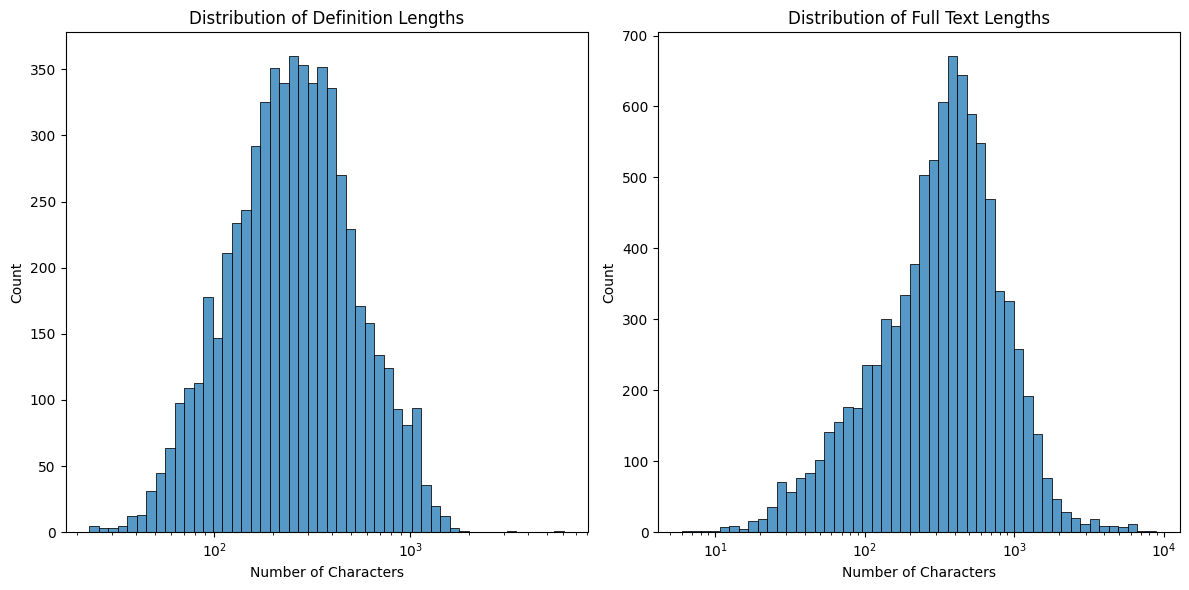

In [ ]:
# Plot the distribution of text lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(icd11_df['definition_length'][icd11_df['definition_length'] > 0], bins=50, log_scale=True)
plt.title('Distribution of Definition Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(icd11_df['full_text_length'][icd11_df['full_text_length'] > 0], bins=50, log_scale=True)
plt.title('Distribution of Full Text Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# Combine and analyze various text fields
icd11_df['all_text'] = icd11_df.apply(
    lambda row: ' '.join([
        str(row['title'] or ''),
        str(row['definition'] or ''),
        str(row['inclusions'] or ''),
        str(row['index_terms'] or ''),
        str(row['full_text'] or '')
    ]), axis=1
)

# Check the length of combined text
icd11_df['all_text_length'] = icd11_df['all_text'].apply(len)

# Identify entries with minimal text
min_text_entries = icd11_df[icd11_df['all_text_length'] < 50]
print(f"Number of entries with limited text: {len(min_text_entries)}")
print(min_text_entries[['code', 'title', 'all_text_length']].head())

Number of entries with limited text: 36
        code               title  all_text_length
809   2A01.0         Meningiomas               35
1290  2A00.0    Gliomas of brain               45
1451  2E80.0              Lipoma               25
1733     NaN  Diseases of spleen               49
1865    4B02         Eosinopenia               35


In [ ]:
# Analyze the hierarchical structure to potentially borrow text from parents/children
def analyze_hierarchy_depth(df):
    # Create a dictionary to store parent-child relationships
    parent_child_dict = {}
    for _, row in df.iterrows():
        if pd.notna(row['parent']):
            parent = row['parent']
            if parent not in parent_child_dict:
                parent_child_dict[parent] = []
            parent_child_dict[parent].append(row['code'])

    # Count children per parent
    children_counts = {parent: len(children) for parent, children in parent_child_dict.items()}

    # Analyze the distribution
    child_counts = list(children_counts.values())
    if child_counts:
        print(f"Average children per parent: {np.mean(child_counts):.2f}")
        print(f"Max children per parent: {np.max(child_counts)}")
        print(f"Parents with >10 children: {sum(1 for count in child_counts if count > 10)}")
    else:
        print("No parent-child relationships found.")

    return parent_child_dict

hierarchy_dict = analyze_hierarchy_depth(icd11_df)

Average children per parent: 3.84
Max children per parent: 27
Parents with >10 children: 85


## 2. Data Preprocessing

In [ ]:
import nltk
nltk.download('punkt_tab')

def preprocess_text(text, stemming=True):
    """
    Preprocess text by applying tokenization, stop-word removal, and stemming.
    """
    if pd.isna(text) or text == '':
        return ''

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags and special characters
    text = re.sub('<.*?>', '', text)
    text = re.sub('[^a-zA-Z0-9\s]', ' ', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Apply stemming if requested
    if stemming:
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

# Apply preprocessing to all text fields
for col in ['title', 'definition', 'inclusions', 'index_terms', 'full_text']:
    icd11_df[f'{col}_processed'] = icd11_df[col].fillna('').apply(preprocess_text)

# Create combined processed text field
icd11_df['all_text_processed'] = icd11_df.apply(
    lambda row: ' '.join([
        row['title_processed'],
        row['definition_processed'],
        row['inclusions_processed'],
        row['index_terms_processed'],
        row['full_text_processed']
    ]), axis=1
)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
def enrich_text_with_hierarchy(df, hierarchy_dict):
    """
    Enrich text descriptions by considering the hierarchical structure.
    For entries with minimal text, borrow content from parents and children.
    """
    # Create a code to index mapping for faster lookups
    code_to_idx = {code: idx for idx, code in enumerate(df['code'])}

    # Function to get parent's text
    def get_parent_text(code):
        if code in df['parent'].values:
            parent_codes = df[df['code'] == code]['parent'].values
            parent_texts = []
            for parent_code in parent_codes:
                if parent_code in code_to_idx:
                    parent_idx = code_to_idx[parent_code]
                    parent_text = df.iloc[parent_idx]['all_text_processed']
                    parent_texts.append(parent_text)
            return ' '.join(parent_texts)
        return ''

    # Function to get children's text
    def get_children_text(code):
        if code in hierarchy_dict:
            children = hierarchy_dict[code]
            children_texts = []
            for child in children:
                if child in code_to_idx:
                    child_idx = code_to_idx[child]
                    child_text = df.iloc[child_idx]['all_text_processed']
                    children_texts.append(child_text)
            return ' '.join(children_texts)
        return ''

    # Enrich text for entries with minimal content
    enriched_texts = []

    for _, row in df.iterrows():
        code = row['code']
        text = row['all_text_processed']

        # If text is minimal, try to enrich it
        if len(text.split()) < 10:
            parent_text = get_parent_text(row['parent']) if pd.notna(row['parent']) else ''
            children_text = get_children_text(code)

            # Combine with original text, prioritizing original content
            enriched_text = text
            if parent_text:
                enriched_text += f" {parent_text}"
            if children_text:
                enriched_text += f" {children_text}"

            enriched_texts.append(enriched_text)
        else:
            enriched_texts.append(text)

    return enriched_texts

# Apply text enrichment
icd11_df['enriched_text'] = enrich_text_with_hierarchy(icd11_df, hierarchy_dict)

# Check improvement in text length
icd11_df['enriched_text_length'] = icd11_df['enriched_text'].apply(lambda x: len(x.split()))
print(f"Original minimal text entries (< 10 words): {len(icd11_df[icd11_df['all_text_processed'].apply(lambda x: len(x.split())) < 10])}")
print(f"Remaining minimal text entries after enrichment: {len(icd11_df[icd11_df['enriched_text_length'] < 10])}")

Original minimal text entries (< 10 words): 440
Remaining minimal text entries after enrichment: 440


:(

In [ ]:
icd11_df.head()

,id,code,title,browser_url,class_kind,definition,parent,inclusions,foundation_children,foundation_child_references,...,all_text,all_text_length,title_processed,definition_processed,inclusions_processed,index_terms_processed,full_text_processed,all_text_processed,enriched_text,enriched_text_length
0,1937339080,1C22,Infections due to Chlamydia psittaci,https://icd.who.int/browse/2023-01/mms/en#1937...,category,Any condition caused by an infection with the ...,1127435854,Psittacosis; Ornithosis; Parrot fever,Pneumonia in chlamydia psittaci infection,Pneumonia in chlamydia psittaci infection: htt...,...,Infections due to Chlamydia psittaci Any condi...,1391,infect due chlamydia psittaci,condit caus infect gram negat bacteria chlamyd...,psittacosi ornithosi parrot fever,infect due chlamydia psittaci psittacosi ornit...,infect due chlamydia psittaci condit caus infe...,infect due chlamydia psittaci condit caus infe...,infect due chlamydia psittaci condit caus infe...,128
1,1671640403,1F51.0,Gambiense trypanosomiasis,https://icd.who.int/browse/2023-01/mms/en#1671...,category,A disease caused by an infection with the prot...,875488052,West African sleeping sickness; Infection due ...,NaN,NaN,...,Gambiense trypanosomiasis A disease caused by ...,1061,gambiens trypanosomiasi,diseas caus infect protozoan parasit trypanoso...,west african sleep sick infect due trypanosoma...,,gambiens trypanosomiasi diseas caus infect pro...,gambiens trypanosomiasi diseas caus infect pro...,gambiens trypanosomiasi diseas caus infect pro...,98
2,1528414070,1A07,Typhoid fever,https://icd.who.int/browse/2023-01/mms/en#1528...,category,A condition caused by an infection with the gr...,135352227,NaN,NaN,NaN,...,Typhoid fever A condition caused by an infecti...,905,typhoid fever,condit caus infect gram negat bacteria salmone...,,,typhoid fever condit caus infect gram negat ba...,typhoid fever condit caus infect gram negat ba...,typhoid fever condit caus infect gram negat ba...,86
3,328097188,1A36.12,Cutaneous amoebiasis,https://icd.who.int/browse/2023-01/mms/en#3280...,category,NaN,1777228366,NaN,NaN,NaN,...,Cutaneous amoebiasis nan nan Cutaneous amoebia...,177,cutan amoebiasi,,,cutan amoebiasi amoebiasi skin amoeb ulcer skin,cutan amoebiasi cutan amoebiasi amoebiasi skin...,cutan amoebiasi cutan amoebiasi amoebiasi sk...,cutan amoebiasi cutan amoebiasi amoebiasi sk...,18
4,1483190070,1D03,Infectious abscess of the central nervous system,https://icd.who.int/browse/2023-01/mms/en#1483...,category,A focal suppurative process of the brain paren...,1585949804,NaN,NaN,NaN,...,Infectious abscess of the central nervous syst...,2547,infecti abscess central nervous system,focal suppur process brain parenchyma intracra...,,,infecti abscess central nervous system focal s...,infecti abscess central nervous system focal s...,infecti abscess central nervous system focal s...,240


## 3. Vectorization

# 3.1 TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

def create_tfidf_vectors(df, text_column, max_features=16384, n_components=300):
    """
    Create TF-IDF vectors for the given text column and reduce dimensionality.
    """
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=2,
        max_df=0.85,
        stop_words='english'
    )

    # Fit and transform the text data
    tfidf_matrix = vectorizer.fit_transform(df[text_column])
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

    # Reduce dimensionality with SVD (similar to PCA)
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    tfidf_vectors = svd.fit_transform(tfidf_matrix)
    print(f"Reduced TF-IDF vectors shape: {tfidf_vectors.shape}")
    print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")

    return tfidf_vectors, vectorizer, svd

# Create TF-IDF vectors
tfidf_vectors, tfidf_vectorizer, tfidf_svd = create_tfidf_vectors(
    icd11_df, 'enriched_text', max_features=16384, n_components=300
)

# Add vectors to DataFrame
icd11_df['tfidf_vector'] = list(tfidf_vectors)

TF-IDF matrix shape: (8955, 8986)
Reduced TF-IDF vectors shape: (8955, 300)
Explained variance ratio: 0.4373




## TF-IDF Vectorization Explained

### What is TF-IDF?

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects how important a word is to a document in a collection of documents (corpus). It combines two metrics:

1. **Term Frequency (TF)**: How frequently a term appears in a document
2. **Inverse Document Frequency (IDF)**: How rare a term is across all documents

The formula is: TF-IDF = TF × IDF

Words that are common in a single document but rare across all documents receive higher TF-IDF scores, helping to identify distinctive terms.

### Breaking Down the Code

Let's analyze this section step by step:

#### 1. Importing the Libraries

```python
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
```

- `TfidfVectorizer`: This scikit-learn class converts a collection of text documents into a matrix of TF-IDF features
- `TruncatedSVD`: This performs dimensionality reduction, similar to Principal Component Analysis (PCA) but works on sparse matrices

#### 2. The `create_tfidf_vectors` Function

This function takes a DataFrame, a column name containing text, and parameters for controlling the vectorization:

```python
def create_tfidf_vectors(df, text_column, max_features=16384, n_components=300):
```

- `df`: The pandas DataFrame containing your ICD-11 data
- `text_column`: The name of the column containing processed text (in this case, 'enriched_text')
- `max_features`: Maximum number of terms to keep in the vocabulary (16,384)
- `n_components`: How many dimensions to reduce the vectors to (300)

#### 3. TF-IDF Vectorizer Configuration

```python
vectorizer = TfidfVectorizer(
    max_features=max_features,
    min_df=2,
    max_df=0.85,
    stop_words='english'
)
```

- `max_features=16384`: The vectorizer will keep only the top 16,384 terms based on term frequency across the corpus
- `min_df=2`: Ignore terms that appear in fewer than 2 documents (removes very rare terms)
- `max_df=0.85`: Ignore terms that appear in more than 85% of documents (removes overly common terms)
- `stop_words='english'`: Automatically remove English stop words (common words like "the", "and", "in")

#### 4. Creating the TF-IDF Matrix

```python
tfidf_matrix = vectorizer.fit_transform(df[text_column])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
```

This step:
1. Takes all the text from the specified column
2. Tokenizes the text (splits into words)
3. Builds a vocabulary (dictionary of unique terms)
4. Calculates TF-IDF scores for each term in each document
5. Creates a sparse matrix where:
   - Rows represent documents (ICD-11 codes)
   - Columns represent terms in the vocabulary
   - Values are TF-IDF scores

The resulting matrix is huge (number of documents × vocabulary size) but sparse (most values are zero because most documents don't contain most words).

#### 5. Dimensionality Reduction with SVD

```python
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_vectors = svd.fit_transform(tfidf_matrix)
print(f"Reduced TF-IDF vectors shape: {tfidf_vectors.shape}")
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")
```

This step:
1. Creates a `TruncatedSVD` model to reduce dimensions from potentially thousands to just 300
2. Applies the model to the TF-IDF matrix
3. Returns a dense matrix where each document is represented by 300 numbers instead of thousands
4. Reports the "explained variance ratio" - how much of the original information is preserved in the reduced dimensions. In mathematical terms, explained variance measures the proportion of the variance in the original data that is captured by the reduced dimensions. It answers the question: "How much of the original signal are we preserving when we compress the data?"

The SVD identifies the most important patterns in the data and preserves them in the reduced space. This makes the vectors more manageable while retaining most of the meaningful information.

#### 6. Storing the Results

```python
return tfidf_vectors, vectorizer, svd
```

The function returns:
- `tfidf_vectors`: The reduced dimensionality vectors (one per ICD-11 code)
- `vectorizer`: The trained vectorizer object (needed to transform new text later)
- `svd`: The trained SVD model (needed to reduce dimensions of new vectors later)

#### 7. Using the Function

```python
tfidf_vectors, tfidf_vectorizer, tfidf_svd = create_tfidf_vectors(
    icd11_df, 'enriched_text', max_features=16384, n_components=300
)
```

This calls the function on your DataFrame, using the 'enriched_text' column with the specified parameters.

#### 8. Adding Vectors to the DataFrame

```python
icd11_df['tfidf_vector'] = list(tfidf_vectors)
```

This adds a new column to your DataFrame where each cell contains a 300-dimensional vector representing that ICD-11 code. This allows you to store the vectors alongside the original data for easy access.

## Practical Implications

This TF-IDF vectorization approach:

1. **Creates a baseline representation** of each ICD-11 code based purely on word importance
2. **Handles the enormous vocabulary** of medical terminology by keeping only the most important terms
3. **Makes the vectors manageable** by reducing dimensions while preserving semantic relationships
4. **Serves as a useful comparison** to the more sophisticated neural models (BERT, BioBERT)

The advantage of TF-IDF is that it's simple, fast, and requires no training data. It works well for capturing topical similarity since codes that share important medical terms will have similar vectors.

The limitation is that it doesn't capture contextual meaning or semantic relationships between different terms the way neural models do. For example, it wouldn't understand that "myocardial infarction" and "heart attack" refer to the same condition unless they explicitly appear together in documents.

You can use these TF-IDF vectors for similarity search, clustering, or as input features for other machine learning models. The quality of the vectors depends heavily on the quality and richness of the text in the 'enriched_text' column.

In [ ]:
icd11_df

,id,code,title,browser_url,class_kind,definition,parent,inclusions,foundation_children,foundation_child_references,...,all_text_length,title_processed,definition_processed,inclusions_processed,index_terms_processed,full_text_processed,all_text_processed,enriched_text,enriched_text_length,tfidf_vector
0,1937339080,1C22,Infections due to Chlamydia psittaci,https://icd.who.int/browse/2023-01/mms/en#1937...,category,Any condition caused by an infection with the ...,1127435854,Psittacosis; Ornithosis; Parrot fever,Pneumonia in chlamydia psittaci infection,Pneumonia in chlamydia psittaci infection: htt...,...,1391,infect due chlamydia psittaci,condit caus infect gram negat bacteria chlamyd...,psittacosi ornithosi parrot fever,infect due chlamydia psittaci psittacosi ornit...,infect due chlamydia psittaci condit caus infe...,infect due chlamydia psittaci condit caus infe...,infect due chlamydia psittaci condit caus infe...,128,"[0.14189655634124868, -0.009811841156713819, 0..."
1,1671640403,1F51.0,Gambiense trypanosomiasis,https://icd.who.int/browse/2023-01/mms/en#1671...,category,A disease caused by an infection with the prot...,875488052,West African sleeping sickness; Infection due ...,NaN,NaN,...,1061,gambiens trypanosomiasi,diseas caus infect protozoan parasit trypanoso...,west african sleep sick infect due trypanosoma...,,gambiens trypanosomiasi diseas caus infect pro...,gambiens trypanosomiasi diseas caus infect pro...,gambiens trypanosomiasi diseas caus infect pro...,98,"[0.10431935807979659, -0.003425322663250276, 0..."
2,1528414070,1A07,Typhoid fever,https://icd.who.int/browse/2023-01/mms/en#1528...,category,A condition caused by an infection with the gr...,135352227,NaN,NaN,NaN,...,905,typhoid fever,condit caus infect gram negat bacteria salmone...,,,typhoid fever condit caus infect gram negat ba...,typhoid fever condit caus infect gram negat ba...,typhoid fever condit caus infect gram negat ba...,86,"[0.1342964564909032, -0.012022054359943163, 0...."
3,328097188,1A36.12,Cutaneous amoebiasis,https://icd.who.int/browse/2023-01/mms/en#3280...,category,NaN,1777228366,NaN,NaN,NaN,...,177,cutan amoebiasi,,,cutan amoebiasi amoebiasi skin amoeb ulcer skin,cutan amoebiasi cutan amoebiasi amoebiasi skin...,cutan amoebiasi cutan amoebiasi amoebiasi sk...,cutan amoebiasi cutan amoebiasi amoebiasi sk...,18,"[0.04449905682707777, 0.01423380455220891, 0.0..."
4,1483190070,1D03,Infectious abscess of the central nervous system,https://icd.who.int/browse/2023-01/mms/en#1483...,category,A focal suppurative process of the brain paren...,1585949804,NaN,NaN,NaN,...,2547,infecti abscess central nervous system,focal suppur process brain parenchyma intracra...,,,infecti abscess central nervous system focal s...,infecti abscess central nervous system focal s...,infecti abscess central nervous system focal s...,240,"[0.16261164937306355, 0.010623145030387107, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8950,1122633896,LA90.12,Lymphatic malformations of certain specified s...,https://icd.who.int/browse/2023-01/mms/en#1122...,category,NaN,1456264474,NaN,NaN,NaN,...,1483,lymphat malform certain specifi site,,,lymphat malform certain specifi site lymphat m...,lymphat malform certain specifi site lymphat m...,lymphat malform certain specifi site lymphat...,lymphat malform certain specifi site lymphat...,128,"[0.05627697533931542, 0.02630599822310978, 0.0..."
8951,1615657779,LB70.1,Wormian bones,https://icd.who.int/browse/2023-01/mms/en#1615...,category,"Also known as intrasutural bone, is an additio...",1640384948,NaN,NaN,NaN,...,655,wormian bone,also known intrasutur bone addit boni segment ...,,wormian bone,wormian bone also known intrasutur bone addit ...,wormian bone also known intrasutur bone addit ...,wormian bone also known intrasutur bone addit ...,66,"[0.058222649436963245, 0.013685888211696603, 0..."
8952,66705662,LA07.0,Primary tethered cord syndrome,https://icd.who.int/browse/2023-01/mms/en#

In [ ]:
icd11_df['tfidf_vector'][0]

array([ 1.41896556e-01, -9.81184116e-03,  1.77009912e-01, -5.45887567e-02,
       -1.56194240e-01, -1.30102832e-01, -1.17959233e-01, -9.30884205e-02,
        2.68599626e-02, -2.36180301e-02, -1.50872916e-01,  1.07545425e-01,
       -9.78740227e-02,  4.86729414e-04,  6.63851092e-02,  9.98451865e-02,
        6.28216869e-02, -6.24246846e-02, -9.46316922e-02,  5.45878090e-02,
       -2.01979359e-02, -7.34876903e-02,  3.51377839e-02, -8.62217707e-02,
        1.78160405e-02,  1.52264841e-02, -3.53947902e-03,  1.20071793e-02,
       -1.03941144e-01, -8.72127035e-03, -1.55222442e-02,  4.02069023e-03,
       -2.77683551e-02,  7.26884376e-02, -8.93001968e-02,  5.41153618e-02,
       -3.48228605e-04,  1.97763627e-02,  3.73176785e-02, -1.88325846e-02,
        4.02308951e-02,  2.90176088e-02,  3.59282777e-02,  1.63457935e-03,
       -2.02327204e-02, -5.70274407e-02, -3.31856050e-02, -6.10723228e-03,
        4.68766935e-02, -4.03313530e-02,  2.55282331e-02, -3.36146564e-02,
        6.59422247e-03,  

## Understanding the Vector Representation

This vector is a numerical representation of the first ICD-11 code entry (which based on the notebook appears to be "Infections due to Chlamydia psittaci"). What you're seeing is the result of applying TF-IDF vectorization followed by dimensionality reduction using Truncated SVD (Similar to PCA).

### What This Vector Represents

1. **Semantic Meaning in Vector Space**: Each dimension in this 300-dimensional vector captures some aspect of the meaning of the medical term. Together, these dimensions position the code in a multi-dimensional space where similar medical concepts are positioned closer together.

2. **Reduced Dimensions**: The original TF-IDF matrix was much larger (with over 12,000 features representing different terms), but it was compressed down to 300 dimensions to make it more manageable while preserving the most important patterns. The notebook showed that these 300 dimensions captured about 35% of the variance in the original data.

3. **Values and Meaning**: Each number in the vector represents the strength of association with a particular latent feature. Positive values indicate positive association with a concept, negative values indicate negative association, and values close to zero indicate little relevance to that dimension.

### Interpreting Specific Features

Unlike with word embeddings where some dimensions might correspond to interpretable concepts (like gender or tense), the dimensions in SVD-reduced TF-IDF vectors don't usually have clear interpretations. They represent abstract "topics" or patterns in the data.

Some observations from this vector:

- The largest positive value is 0.185869841, at index 53
- The largest negative value is -0.0942302142, at index 13
- Many values are close to zero, indicating that many of the latent features aren't strongly relevant to this particular medical code

## Practical Usage of This Vector

This vector serves several important purposes:

1. **Similarity Calculations**: By computing cosine similarity between this vector and others, you can find the most similar ICD-11 codes.

2. **Search Functionality**: When a user enters a query describing symptoms or a condition, the query can be transformed into the same vector space and then compared with these vectors to find the most relevant ICD codes.

3. **Clustering**: These vectors can be used to group similar medical codes together.

4. **Dimensionality Reduction for Visualization**: The 300 dimensions can be further reduced to 2 or 3 dimensions using techniques like t-SNE or UMAP for visualization purposes.

In the context of the Open Doctor project, these vectors form the foundation of a semantic search system that can match natural language descriptions of medical conditions to standardized ICD-11 codes.
